In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from D_Age_Technologies import *
from E_Age_CompanyType import *

sns.set_style('darkgrid')
sns.set_palette('viridis')

DATA_PATH_2020 = '../Dataset/2020.csv'
DATA_PATH_2019 = '../Dataset/2019.csv'
DATA_PATH_2018 = '../Dataset/2018.csv'

df_2018 = pd.read_csv(DATA_PATH_2018)
df_2019 = pd.read_csv(DATA_PATH_2019)
df_2020 = pd.read_csv(DATA_PATH_2020)

COMPANY_TYPE = 'Company type'
AGE = 'Age'
AGE_SEGMENT = 'age_segment'

def merge(data_frames, common_columns=[]):
    return pd.concat(data_frames, ignore_index=True)[common_columns]

def clean_company_types(df):
    for indx, row in df.iterrows():
        if row[COMPANY_TYPE] is not None and type(row[COMPANY_TYPE]) is not float:
            # remove leading and trailing spaces
            # change to lower case
            processed_value = row[COMPANY_TYPE].strip().lower().replace("-", "")
            # normalize words by grouping those with same stem
            if ("consult" in processed_value):
                processed_value = 'consultancy'
            elif("research" in processed_value or "institut" in processed_value or "education" in processed_value):
                processed_value = 'research'
            elif ("commerc" in processed_value):
                processed_value = 'ecommerce'
            elif ("corporat" in processed_value):
                processed_value = 'corporate'
            elif ("outso" in processed_value): # most probably this is outsource but to also consider mis-spellings
                processed_value = 'outsource'
            
            # Map the responder's company type to coresponding more general company type
            if processed_value in company_type_mapping:
                processed_value = company_type_mapping[processed_value]

            df.loc[indx, COMPANY_TYPE] = processed_value
    return df

def correlation_ratio(df, numerical_column, categorical_column):
    grouped = df.groupby(categorical_column)[numerical_column]
    means = grouped.mean()
    overall_mean = df[numerical_column].mean()

    between_group = sum(grouped.count() * (means - overall_mean) ** 2)

    within_group = np.sum((df[numerical_column] - df[categorical_column].map(means)) ** 2)
    total = between_group + within_group

    eta_squared = between_group / total
    eta = np.sqrt(eta_squared)
    return eta

In [2]:
merged_df = merge(data_frames=[df_2018, df_2019, df_2020], common_columns=[AGE, COMPANY_TYPE])
assert merged_df.shape[0] == df_2018.shape[0] + df_2019.shape[0] + df_2020.shape[0]

<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> State & Refine QS</h1></div>

> #### _`QS:`_ How does age affect the type of company that a person is joining? In other words, do startups tend to have people with a smaller age?
>|Set Expectation | Collect Info | Match Results| 
>|----|----|----|
>| Question is answerable, there exist enough company types to answer it.| There is a variety of 102 company types | _`Matches`_ |
> |Younger people are more likely to work in startups. <br><br>People above 35 are more likely to work for big sized corporates| 63.5% and 20.04% of the company types are `product` and `startup`, respectivley. However, it is important to note that the label `product` does not necessarily indicate the size of the company. Instead, it typically refers to a company that primarily focuses on developing and manufacturing tangible goods or physical products, irrespective of its scale.| ❌ Our initial expectation does not align with the data we have collected. Therefore, we need to modify our question from focusing on the company size to focusing on the company business type, to incorporate the insights gained from the data.|
<br>

> #### _`New QS:`_ Is there a relation between the age of employee and the type of company he/she is joining?



<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Explore Data</h1></div>

## Analysis Outlines
- Univariate analysis: the distribution of company types (histogram)
- Bivariate analysis: relation between the age and the company types (box plot)
- Hypothesis testing: joining a company type depends on the age

### Univariate Analysis on Company Type

In [4]:
print("Before Cleaning")
print("Number of unique company types for 2018 responders", len(df_2018[COMPANY_TYPE].unique()))
print("Number of unique company types for 2019 responders", len(df_2019[COMPANY_TYPE].unique()))
print("Number of unique company types for 2020 responders", len(df_2020[COMPANY_TYPE].unique()))
print("Total Number of unique company types", len(merged_df[COMPANY_TYPE].unique()))

Before Cleaning
Number of unique company types for 2018 responders 50
Number of unique company types for 2019 responders 8
Number of unique company types for 2020 responders 64
Total Number of unique company types 102


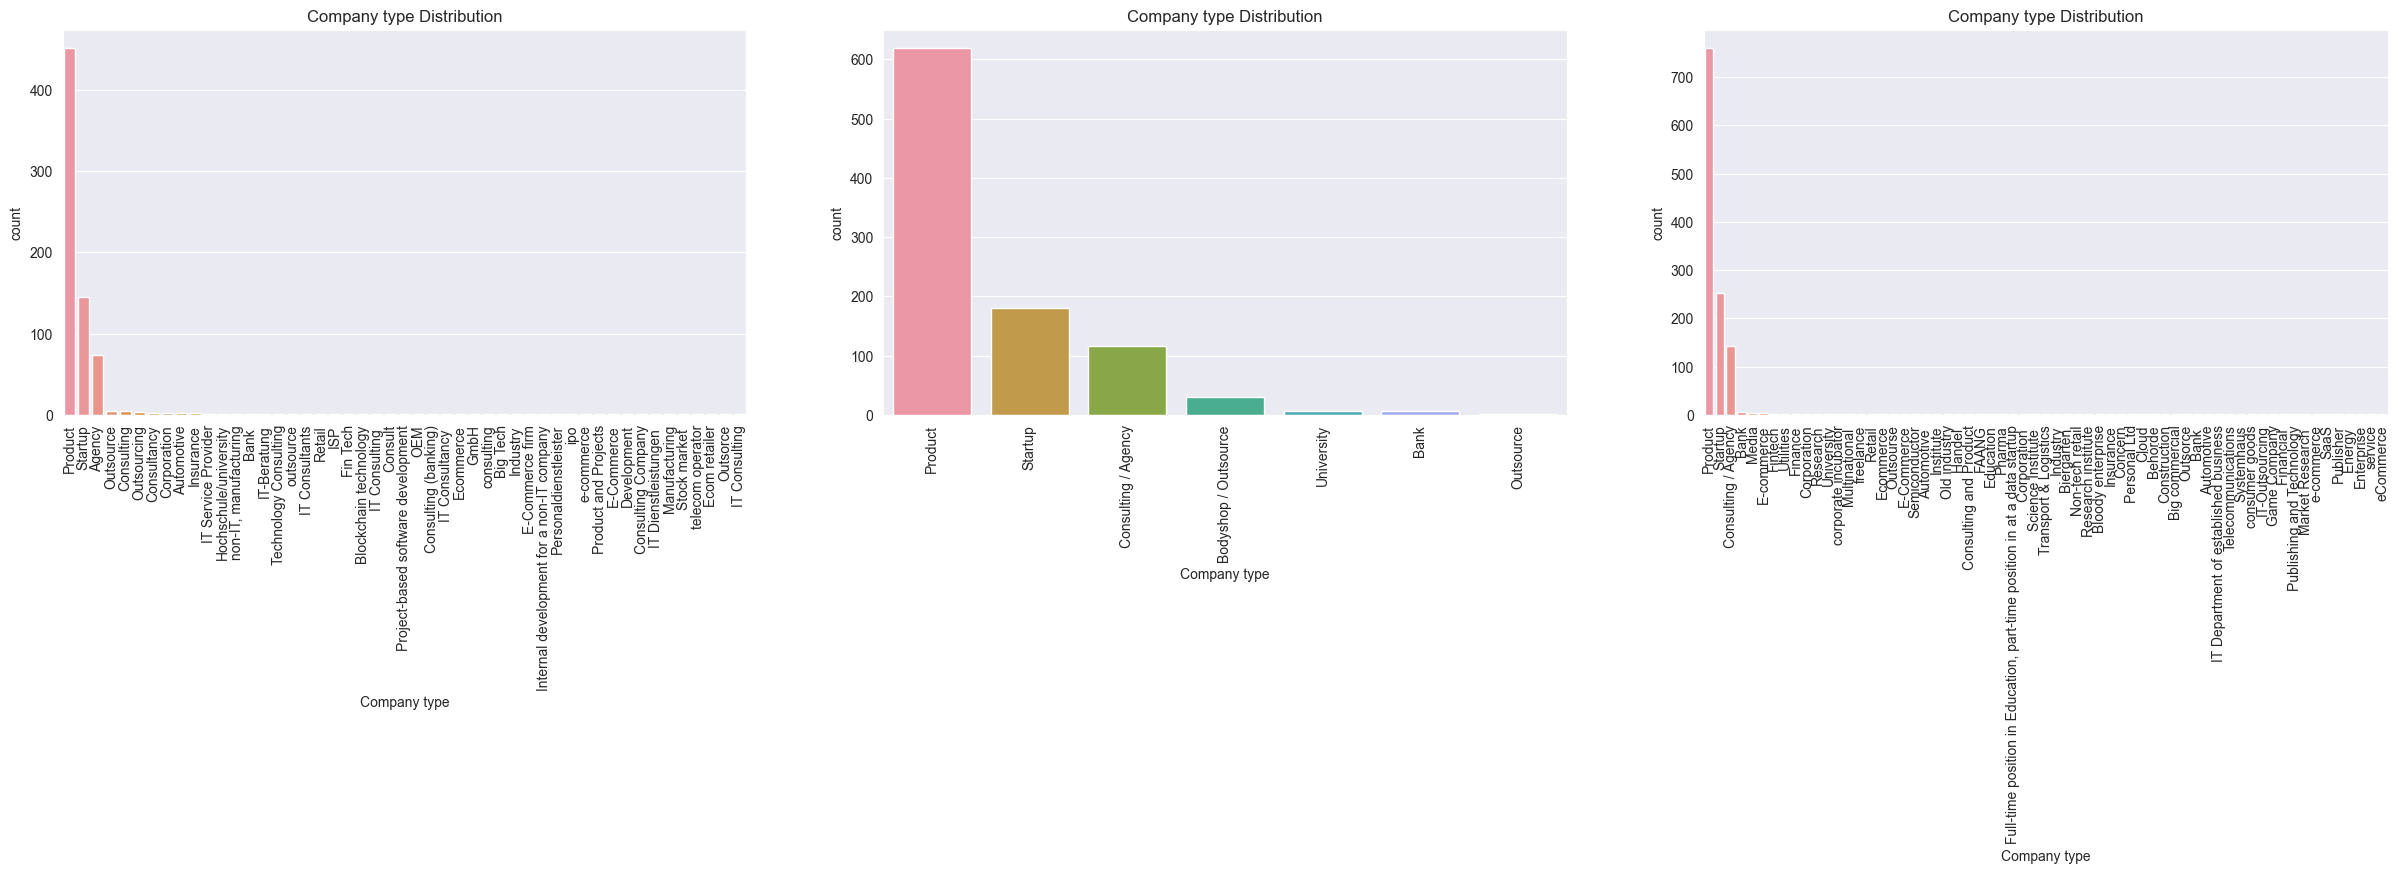

In [5]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 1)
plt_univariate_histogram(df_2018, COMPANY_TYPE)
plt.subplot(1, 3, 2)
plt_univariate_histogram(df_2019, COMPANY_TYPE)
plt.subplot(1, 3, 3)
plt_univariate_histogram(df_2020, COMPANY_TYPE)
plt.show()

It's shown that the most frequent company types are being almost the same across the 2018, 2019, and 2020 datasets.

#### Normalizing and Enforcing Consistency on Compnay Type

In [6]:
print("Before Normalizing, Number of unique types", len(merged_df[COMPANY_TYPE].unique()))
cleaned_df = clean_company_types(merged_df.copy())
print("After Normalizing, Number of unique types", len(cleaned_df[COMPANY_TYPE].unique()))

Before Normalizing, Number of unique types 102
After Normalizing, Number of unique types 40


>|Set Expectation | Collect Info | Match Results| 
>|----|----|----|
>| The company type is divided into a few categories, such as `Product` or `Startup.`| There is a variety of 102 company types | ❌This is because it’s a survey, where people either choose or write in a text field the type of the company they work at. <br><br>In 2018 and 2020, there are many variations in the company types filled by survey responders, including "Technology Consulting," "IT Consultants," "IT Consulting," and more. <br><br> Since the column primarily focuses on the company type rather than the specific business sector, it is possible to group several categories into one generic company type. For example, any type of company related to consulting can be considered as a generic consulting company. Also, group the types with the same stem together, and unify the capitalization of the text. |

**Stemming and Cleaning**

Through applying the stemming and capitalization cleaning, the number of unique company types was reduced from 102 to 72.

**Clustering**

By visually inspecting and analyzing the 75 different company types, we aim to cluster and group them into more generalized categories. This approach allows us to reduce the overall number of company types while increasing the frequency of occurrence for each category. Rather than simply removing sparse company types with low frequencies, we utilize human judgment to create more meaningful and consolidated clusters. For instance, the words `media`, `publishing and technology` and `publisher` was placed under the category: `Media/Publishing`.

Doing so, the number of unique company types was reduced from 72 to 40.

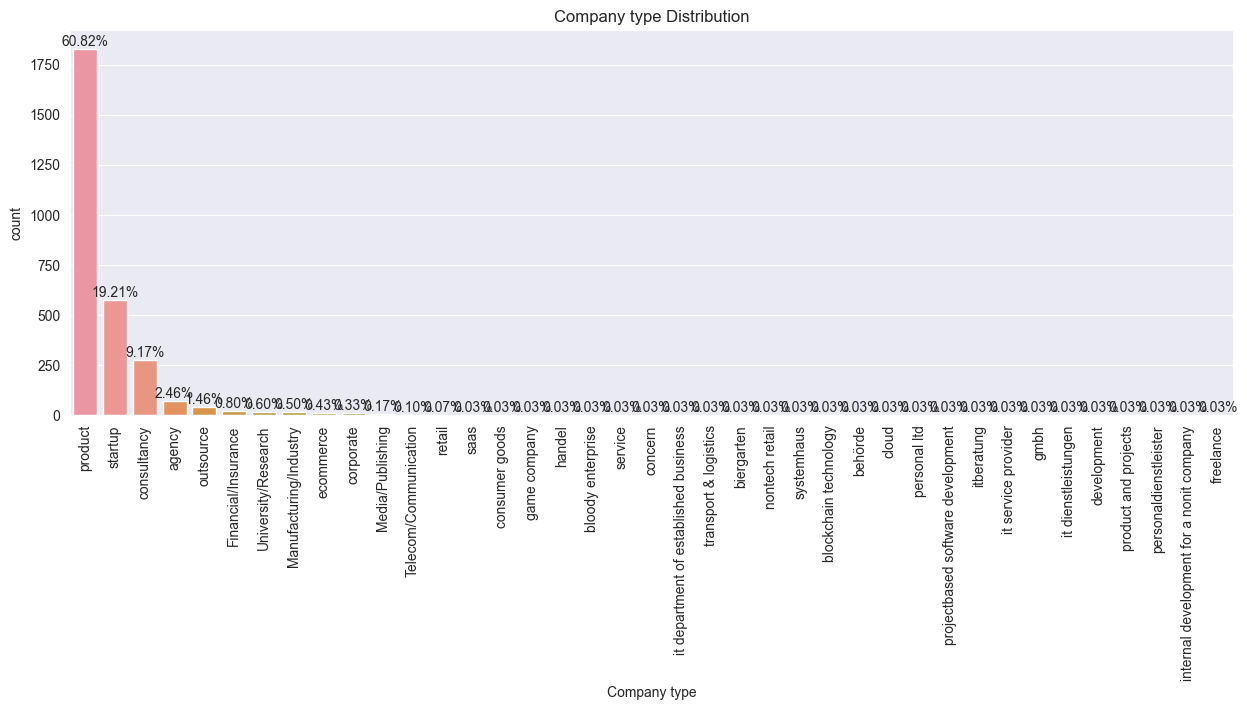

In [7]:
plt.figure(figsize=(15, 5))
plt_univariate_histogram(cleaned_df, COMPANY_TYPE, show_percentage=True)

> ***
> ### _`Interpretations:`_
> - _`Product company type is dominating. Why???????`_
> - _`Most Dominating company types are `prodcut`, `startup`, `consultancy` and `agency`, this is beacuse the survey the data was collected through have them as choices, and an other text field. Responders will usually choose an existing option rather than writing in the others text field.`_
![Company Type Survey](../Images/company_type_survey.png)
> - _`The remaining company types have very low frequencies, making it unreliable to conduct analysis using them. Therefore, we will filter out company types that have fewer than 10 respondents.`_

In [8]:
print("Before filtering out rows with low type frequency")
print("Number of unique types", len(cleaned_df[COMPANY_TYPE].unique()))
print("# rows", cleaned_df.shape[0])

type_counts = cleaned_df[COMPANY_TYPE].value_counts()
type_counts = type_counts[type_counts >= 10]
cleaned_df = cleaned_df[cleaned_df[COMPANY_TYPE].isin(type_counts.index)]

print("After filtering out rows with low type frequency")
print("Number of unique types", len(cleaned_df[COMPANY_TYPE].unique()))
print("# rows", cleaned_df.shape[0])


Before filtering out rows with low type frequency
Number of unique types 40
# rows 3009
After filtering out rows with low type frequency
Number of unique types 10
# rows 2882


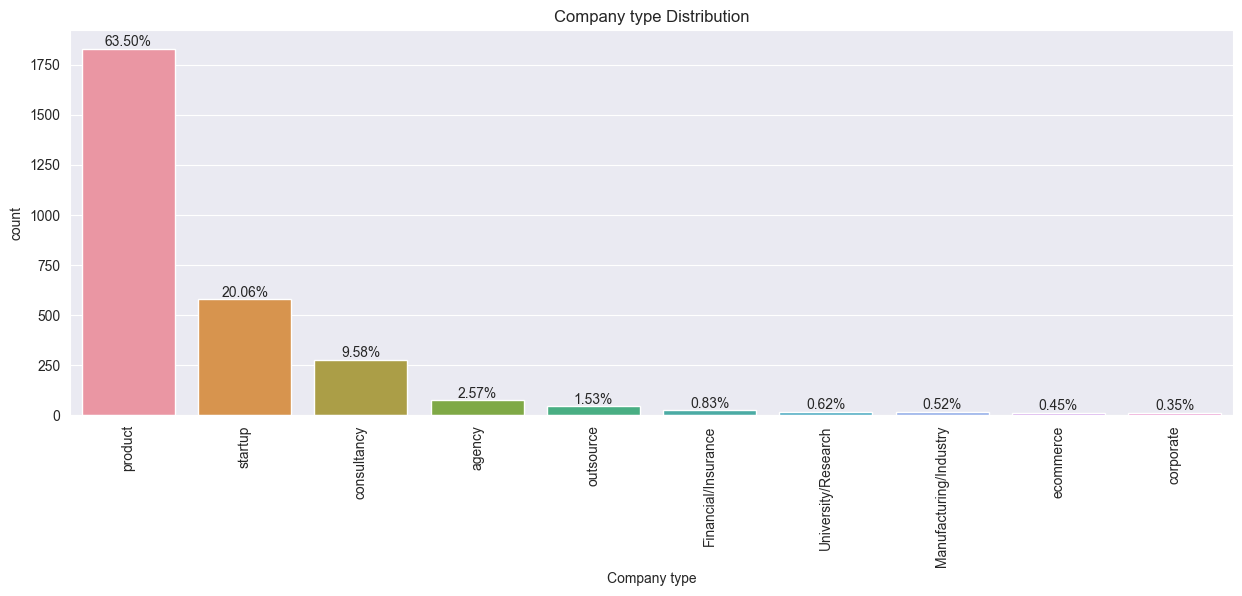

In [9]:
plt.figure(figsize=(15, 5))
plt_univariate_histogram(cleaned_df, COMPANY_TYPE, show_percentage=True)

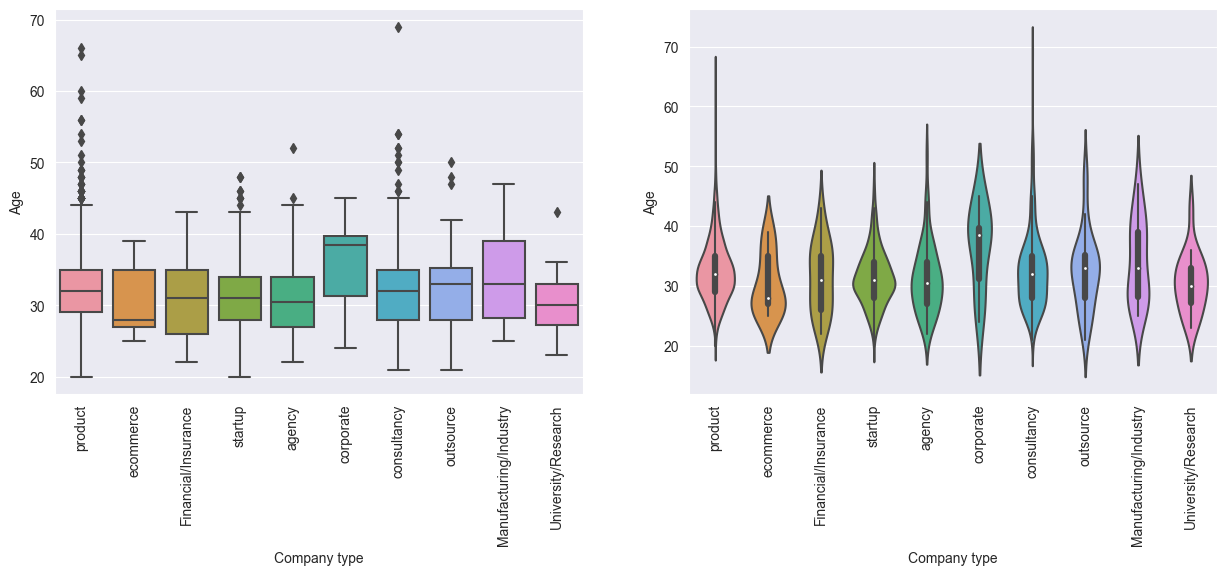

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(x=COMPANY_TYPE, y=AGE, data=cleaned_df)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.violinplot(x=COMPANY_TYPE, y=AGE, data=cleaned_df)
plt.xticks(rotation=90)
plt.show()

> ***
> ### _`Interpretations:`_
> - _`Most company types have most of their employees around the age of 30 because the majority of this survey’s responders are around the age of 30.`_
> - _`In the `consultancy`  company type, we observe the presence of outliers or higher age values. This can be attributed to the fact that older employees, who have accumulated significant experience over the years, are more likely to work as consultants and provide valuable advice within a consultancy company. `_
> - _`Most people working in `ecommerce` are below 30 years unlike other company types. This observation can be attributed to the fact that younger individuals are more familiar with technology, online platforms, and the digital landscape. Given the nature of ecommerce businesses that heavily rely on online transactions and digital marketing, younger employees may possess the necessary skills, adaptability, and understanding of modern consumer behavior, making them well-suited for this industry.`_ 
>- _`Most people who works in `corporate`, companies characterized by their hierarchical organizational structure, are around 40 years`_

In [11]:
# Categorize age into age bins
cleaned_df = segment_age(cleaned_df)

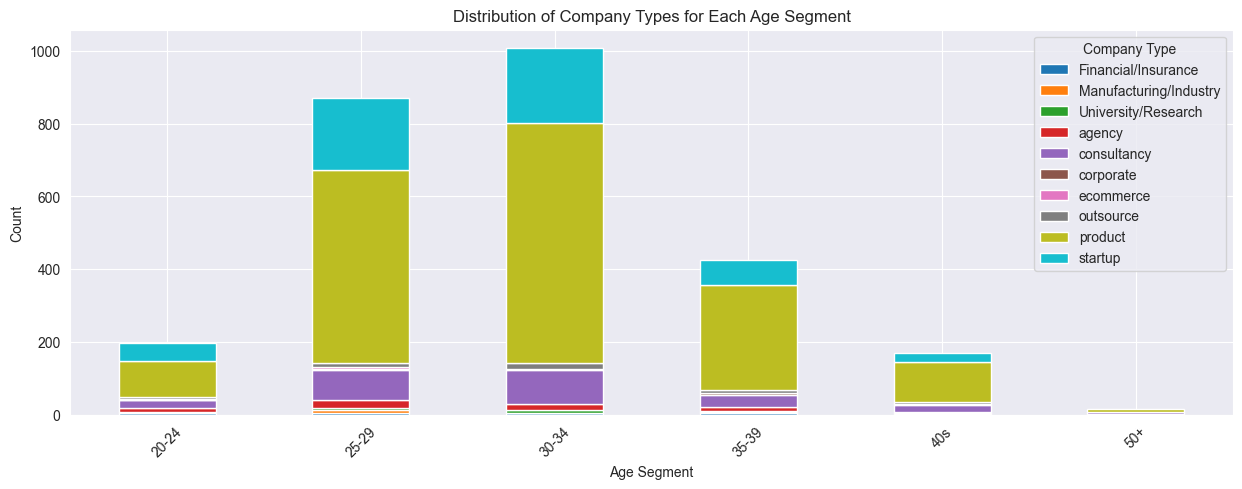

In [12]:
segment_counts = cleaned_df.groupby([AGE_SEGMENT, COMPANY_TYPE]).size().unstack()
segment_counts.plot(kind='bar', stacked=True, figsize=(15, 5), colormap='tab10')
plt.xlabel('Age Segment')
plt.ylabel('Count')
plt.title('Distribution of Company Types for Each Age Segment')
plt.legend(title='Company Type')
plt.xticks(rotation=45)
plt.show()

> - _`The distribution of company types within each age segment is similar to the overall distribution of company types across all age groups. This may indicate no apparent relationship between age and company type. Visual analysis alone may not provide a conclusive assessment of the relationship, Thus we'll establish a statistically valid conclusion through performing a formal statistical test, such as a chi-square test`_

<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Build Models</h1></div>

To determine does changing a company type leds to change in the age of its employees, a correlation ratio will be calculated.

> ***
> $ \eta^{2} = \frac  {\sigma ^{2}_{y^{-}}} {\sigma^{2}_{y}} $
> where:
> - $\eta^{2}$ : correlation ratio
> - $ {\sigma ^{2}_{y^{-}}} $ : is standard deviation between the groups e.g {Startup, Product, etc.}
> - $ {\sigma^{2}_{y}} $ : is the standrd deviation within the group + between groups
>
>In other simple words it is : $ correlationRatio = \frac  {betweenGroups} {betweenGroups+withinGroup} $
>

In [13]:
correlation_ratio(df=cleaned_df, numerical_column=AGE, categorical_column=COMPANY_TYPE)

0.11249500196842509

> - _`The correlation ratio is smaller than 1, which indicates a large variation of age within each company type separatly.`_
> - _`This implies that company types don't have a specific age lies inside it.`_


In [14]:
# hypothesis: the age interval affects the type of the company you will work in
# test: chi-square test
from scipy.stats import chi2_contingency

alpha = 0.05
age_segments = cleaned_df[AGE_SEGMENT].dropna().unique()
company_types = ['startup', 'product']

# for each age, get the number of people in each company type
data = []
for age_segment in age_segments:
    row = []
    print(age_segment)
    for company_type in company_types:
        count = cleaned_df[(cleaned_df[COMPANY_TYPE] == company_type) & (cleaned_df[AGE_SEGMENT] == age_segment)].shape[0]
        row.append(count)
    data.append(row)

# reshape the data into a 2D array
data = np.array(data)
print(data)

# perform chi-square test
chi2, p, dof, expected = chi2_contingency(data)
print(expected.astype(int))

if p < alpha:
    print("Reject null hypothesis")
else:
    print("Failed to reject the null hypothesis")

print(f'chi2: {chi2}, p: {p}, dof: {dof}')

40s
30-34
20-24
35-39
25-29
50+
[[ 26 111]
 [205 660]
 [ 47  99]
 [ 68 288]
 [199 532]
 [  0   9]]
[[ 33 103]
 [210 654]
 [ 35 110]
 [ 86 269]
 [177 553]
 [  2   6]]
Reject null hypothesis
chi2: 18.74373729536796, p: 0.0021451997899305333, dof: 5


In [15]:
from scipy.stats import fisher_exact

filtered_df = cleaned_df[(cleaned_df[COMPANY_TYPE].isin(['product', 'startup'])) & (cleaned_df[AGE_SEGMENT].isin(['25-29', '40s']))]

# Contingency table
contingency_table = pd.crosstab(filtered_df[AGE_SEGMENT], filtered_df[COMPANY_TYPE]).values

# Apply Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)

print("Odds Ratio:", odds_ratio)
print("p-value:", p_value)


Odds Ratio: 0.6261940332292091
p-value: 0.04393199978167252
